In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import pylab as plt
%pylab inline

from scipy.fft import fft, fftfreq, fftn
from scipy.integrate import simps, cumtrapz
from scipy.signal import correlate as cross_corr

from statsmodels.distributions.empirical_distribution import ECDF as ecdf

from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.model_selection import cross_val_score, StratifiedKFold as skf, train_test_split as tts
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


C:\Users\colin\anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
#Read in data
path = 'Activity Recognition exp/Activity Recognition exp/Phones_accelerometer.csv'
paccel = pd.read_csv(path, index_col=0)

paccel.tail(8)

,Arrival_Time,Creation_Time,x,y,z,User,Model,Device,gt
Index,,,,,,,,,
129045,1424778553265,92263731712000,1.379043,0.306454,9.959755,i,samsungold,samsungold_2,bike
129046,1424778553286,92263752250000,1.532270,0.153227,9.959755,i,samsungold,samsungold_2,bike
129047,1424778553306,92263772270000,1.379043,0.000000,9.959755,i,samsungold,samsungold_2,bike
129048,1424778553315,92263781761000,1.379043,0.153227,9.959755,i,samsungold,samsungold_2,bike
129049,1424778553346,92263812248000,1.379043,0.153227,9.806528,i,samsungold,samsungold_2,bike
129050,1424778553366,92263832267000,1.532270,0.153227,9.806528,i,samsungold,samsungold_2,bike
129051,1424778553386,92263852409000,1.532270,0.000000,9.959755,i,samsungold,samsungold_2,bike
129052,1424778553395,92263861839000,1.379043,0.000000,9.959755,i,samsungold,samsungold_2,bike


In [3]:
#Index from .csv does not match number of rows
vals, counts = np.unique(paccel.reset_index()['Index'], return_counts=True)
print(f'{vals[np.argmax(counts)]} occurs {np.max(counts)} times.')

#Index restarts every time there is a new user/model/device pairing (of which there are 71)
idx = paccel.reset_index().groupby(['User','Model','Device'])['Index'].first()
print(idx.max()) #The index is not perfectly sorted, there are errors but this won't affect feature engineering.

0 occurs 71 times.
8


In [4]:
#gt contains nan values so we impute them with 'no_task'
paccel['gt'] = paccel['gt'].fillna('no_task')

In [5]:
#Let every user/model/device/gt be called a trial. We give each trial a unique id.
paccel['trial'] = paccel[['User','Model','Device','gt']].astype(str).sum(axis=1)
paccel['id'] = pd.Categorical(paccel['trial']).codes
print(f'Number of unique trials: {paccel.id.max()+1}')

Number of unique trials: 485


In [6]:
#Convert xyz cartesian coordinates to spherical coordinates
paccel['rho'] = np.sqrt(paccel['x']**2 + paccel['y']**2 + paccel['z']**2)
paccel['theta'] = np.arctan(paccel['y']/paccel['x']).fillna(0) #nan values occur when theta is north pole
paccel['phi'] = np.arccos(paccel['z']/paccel['rho'])

In [41]:
#Define inverse ecdf function for feature extraction
def inv_ecdf(arr, d=10):
    '''
    Obtains the inverse empirical cumulative distribution function (or quantile function)
    for the given array, where d is the number of quantiles to return that are evenly spaced on the
    unit interval.
    '''
    x = np.sort(arr)
    F = ecdf(arr) #Learns the ecdf of the input array
    q = np.sort(F(x)) #see scipy ECDF documentation        
    return x[np.searchsorted(q, np.linspace(0,1,d))]

def xyz_inv_ecdf(df, d, polar=False):
    '''
    Consumes a dataframe with xyz or rho,theta,phi (spherical) acceleration and returns 'd' evenly spaced quantiles
    along the unit interval for each dimension. Default behavior is cartesian
    '''
    arr = [] #store features for each axis
    coords = ['rho','theta','phi'] if polar else ['x','y','z'] #declare coordinate system
    for axis in coords:
        arr.append(inv_ecdf(df[axis],d))
    return np.concatenate(arr)

def extract_ecdf_features(df, d, remove_mean=True, polar=False):
    '''
    Extracts d evenly spaced quantiles across x, y, and z acceleration (each) of the given
    dataframe df. Returns a dataframe containing the features as columns, individual trials as 
    rows and includes ground truth.
    '''
    #Declare coordinate system
    coords = ['rho','theta','phi'] if polar else ['x','y','z'] 
    
    #Define column names
    cols = [f'{a}_{q}' for a in coords for q in range(1,d+1)]
    
    #Get ecdf features for each trial
    features = []
    for i in df.id.unique():
        trial = df.loc[df.id==i][coords]
        if remove_mean:
            trial = trial - trial.mean() #remove the mean
        features.append(xyz_inv_ecdf(trial, d, polar))
        
    #Construct features dataframe
    ecdf_df = pd.DataFrame(np.stack(features), columns=cols)
    ecdf_df['id'] = df.id.unique()
    
    #Merge ground truth from original dataframe to features df
    gt = df.groupby('id').first().reset_index()[['id','gt']]
    ecdf_df = ecdf_df.merge(gt, on='id')
    
    #Drop id column as it is now not useful as a feature or target
    ecdf_df.drop(columns='id', inplace=True)
    
    return ecdf_df

In [8]:
#Extract features from paccel for d=10
ftr_spher = extract_ecdf_features(paccel, 10, polar=True)
ftr_cart = extract_ecdf_features(paccel, 10)

In [10]:
#Store spherical and cartesian ECDF features as .csv
ftr_spher.to_csv('ECDF_Spherical.csv', index=False)
ftr_cart.to_csv('ECDF_Cartesian.csv', index=False)

In [ ]:
#We now engineer features within the time domain

In [7]:
#Get zero crossings of time series (#of times signal crosses the mean)
def zero_cross(arr):
    '''
    Consumes a series and returns the number of times the signal crosses the
    mean.
    '''
    x = arr.values - arr.mean()
    zc = (x[1:] * x[:-1] < 0).sum() - (x == 0).sum()
    return zc

In [8]:
#Signal Magnitude Area (average area under abs(x,y,z) w/ respect to time)
def sig_mag_area(df):
    '''
    Calculate Signal Magnitude Area over x,y,z axes.
    '''
    t = df['x'].size
    i = df['x'].index.values
    x = df['x'].values - df['x'].mean()
    y = df['y'].values - df['y'].mean()
    z = df['z'].values - df['z'].mean()
    int_sum = simps(abs(x)) + simps(abs(y)) + simps(abs(z))
    return int_sum / t

In [9]:
#Signal Vector Magnitude
def sig_vec_mag(df):
    n = df.shape[0]
    x = (df['x'].values - df['x'].mean())**2
    y = (df['y'].values - df['y'].mean())**2
    z = (df['z'].values - df['z'].mean())**2
    mag_sum = np.sqrt(x + y + z).sum()
    return mag_sum / n

In [73]:
#Engineer Time Domain Features
paccel['mag'] = np.sqrt(paccel['x']**2 + paccel['y']**2 + paccel['z']**2)
source = paccel.groupby('id')
xyzm = ['x','y','z','mag']

#Create DataFrame to append features
time_dom = pd.DataFrame()

#Mean, std
time_dom[['x_mean','y_mean','z_mean','mag_mean']] = source[xyzm].mean()
time_dom[['x_std','y_std','z_std','mag_std']] = source[xyzm].std()

#Median, min, max
time_dom[[f'{d}_med' for d in xyzm]] = source[xyzm].median()
time_dom[[f'{d}_min' for d in xyzm]] = source[xyzm].min() - source[xyzm].mean()
time_dom[[f'{d}_max' for d in xyzm]] = source[xyzm].max() - source[xyzm].mean()

#Range, Root Mean Squared Error
for d in xyzm:
    time_dom[f'{d}_range'] = time_dom[f'{d}_max'] - time_dom[f'{d}_min']
    time_dom[f'{d}_rmse'] = source[d].apply(lambda x: np.sqrt(sum(x.values**2)/x.shape[0]))
    #time_dom[f'{d}_zerx'] = source[d].apply(zero_cross)

#Pearson Correlation and Cross Correlation
time_dom['xy_corr'] = source[['x','y']].corr().reset_index().iloc[::2, -1].values
time_dom['xz_corr'] = source[['x','z']].corr().reset_index().iloc[::2, -1].values
time_dom['yz_corr'] = source[['y','z']].corr().reset_index().iloc[::2, -1].values

#Signal Magnitude Area and Signal Vector Magnitude
time_dom['svm'] = source.apply(sig_vec_mag)
time_dom['sma'] = source.apply(sig_mag_area)
    
#Target label
time_dom['gt'] = source['gt'].first()

In [12]:
#Velocity, integrate time series from start to end using simpsons integration
source[xyzm].min() - source[xyzm].mean()

,x,y,z,mag
id,,,,
0,-4.467219,-2.863671,-3.598599,-3.695255
1,-13.817284,-5.816070,-7.439850,-8.269263
2,-0.849502,-0.420252,-0.323773,-0.326673
3,-14.567050,-8.619600,-7.373358,-8.562762
4,-10.841441,-6.061839,-5.000353,-6.948909
...,...,...,...,...
480,-0.544074,-0.461211,-0.315393,-0.258130
481,-6.172970,-5.008819,-6.207371,-6.075158
482,-4.829948,-5.308264,-3.929539,-4.108857


In [74]:
#KNN
X = time_dom.drop(columns='gt')
y = time_dom['gt']

run_mean = []
run_std = []
for n in range(2,11):
    model = KNN(n_neighbors=n, weights='distance')
    score = cross_val_score(model, X, y, cv=10, scoring='f1_weighted')
    run_mean.append(score.mean())
    run_std.append(score.std())

Text(0.5, 1.0, 'KNN f1 of Time-Domain Features')

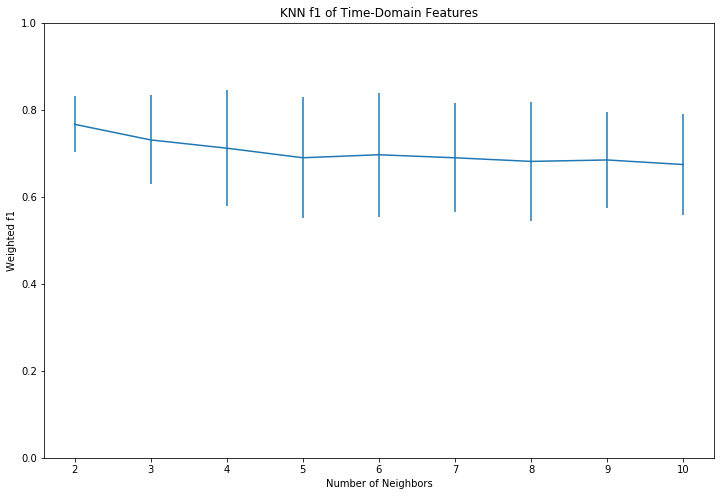

In [75]:
#Plot runs
plt.figure(figsize=(12,8))
plt.errorbar(x=range(2,11), y=run_mean, yerr=run_std)
plt.ylim(0, 1)
plt.ylabel('Weighted f1')
plt.xlabel('Number of Neighbors')
plt.title('KNN f1 of Time-Domain Features')

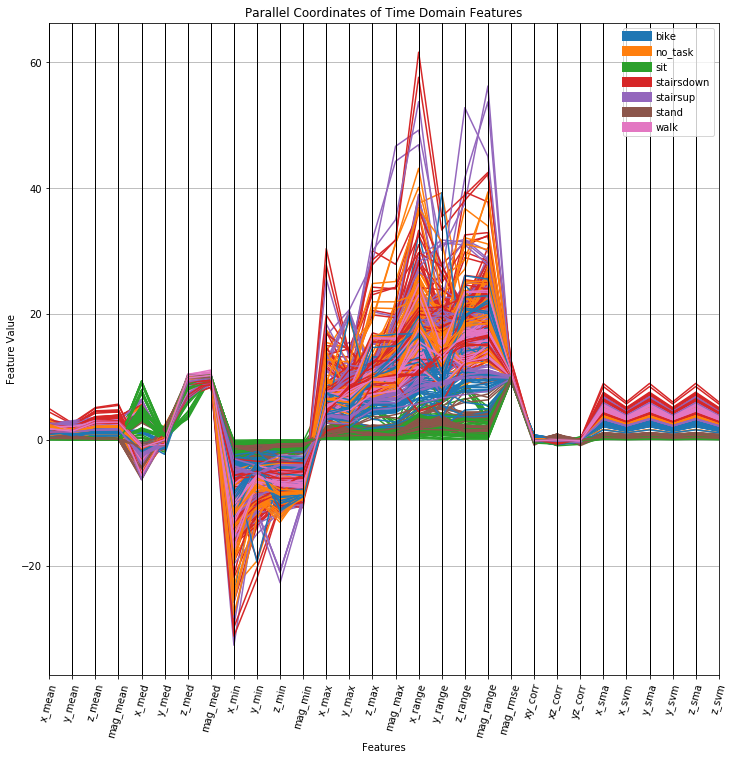

In [38]:
#Plot Separation
plt.figure(figsize=(12,12))
pd.plotting.parallel_coordinates(time_dom, 
                                 'gt', 
                                 color=sns.color_palette(n_colors=7, as_cmap=True), 
                                 ls='-', 
                                 marker=' ',
                                markersize=6)
                                #colormap = sns.color_palette('husl', n_colors=7, as_cmap=True), 
plt.xticks(rotation=75)
plt.title('Parallel Coordinates of Time Domain Features')
plt.ylabel('Feature Value')
plt.xlabel('Features')

leg = plt.legend(loc='top left')
for line in leg.get_lines():
    line.set_linewidth(10.0)

In [192]:
X_train, X_test, y_train, y_test = tts(X, y, test_size=.2, stratify=y)

model.fit(X_train, y_train)
preds = model.predict(X_test)

print(f1_score(y_test, preds, average='weighted'))

0.8624614784217092


In [193]:
confusion_matrix(y_test, preds, labels=y.unique())

array([[12,  0,  0,  1,  0,  1,  0],
       [ 0,  9,  0,  1,  2,  1,  1],
       [ 0,  0, 14,  0,  0,  0,  0],
       [ 1,  0,  0, 13,  0,  0,  0],
       [ 0,  1,  0,  2, 10,  0,  1],
       [ 0,  0,  0,  0,  0, 13,  0],
       [ 0,  1,  0,  0,  0,  0, 13]], dtype=int64)

In [44]:
colp = sns.diverging_palette(-10, 20, as_cmap=True)

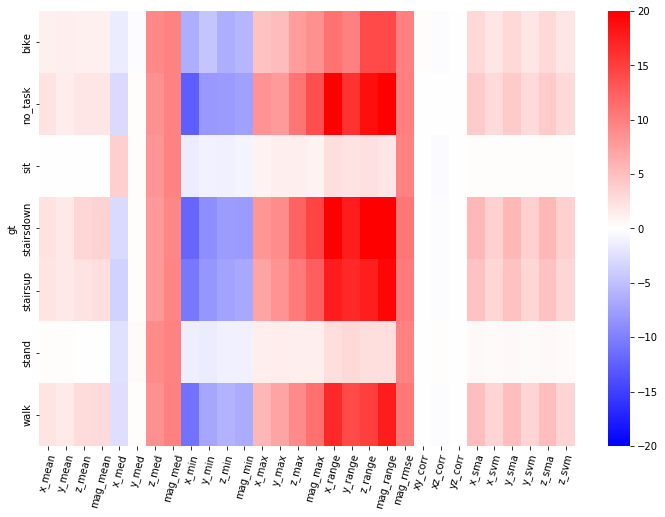

In [57]:
plt.figure(figsize=(12,8))
sns.heatmap(time_dom.groupby('gt').mean(), center=0, cmap='bwr', vmin=-20, vmax=20)
plt.xticks(rotation=75);

In [78]:
time_dom.to_csv('Time_Domain_Features.csv', index=False)